In [2]:
#imports
from os.path import abspath,join,dirname,normpath,basename
from os import makedirs,rename,rmdir
import requests,io
import shutil
import seaborn as sns
import numpy as np
import zipfile
import math
import pandas as pd
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(16,8.27)})

In [3]:
# functions
# replaces NaN value with mean if too much, else just removes (this is from my clinic, it's not perfect)
def handling_nan(given_data, thres):
    number_of_rows = given_data.shape[0]
    num_of_nan = given_data.isna().sum()
    num_of_minus = 0


    for i in range(len(given_data.columns)):
        col = given_data.columns[i]

        # checks if col is int or float (so we can replace it with median -> with median because if we take the mean for replacing then it would mess up the nominal features)
        if (given_data.dtypes[i] == np.float64) or (given_data.dtypes[i] == np.int64):

            # col has nan or -1 (what the "factorize" function turns nan into)
            if (num_of_nan[i] != 0) or (-1 in given_data[col].unique()):

                # variables for replacing
                df_without_minus = given_data[given_data[col] != -1]
                median_of_col = df_without_minus[col].median()

                # even though unlikely, the median can be nan -> so setting to 0 as default
                if math.isnan(median_of_col):
                    median_of_col = 0

                # if col contains -1, get how many -1 it contains
                if -1 in given_data[col].unique():
                    num_of_minus = given_data[col].value_counts()[-1]

                # too many nan, can't drop so replace with mean
                if num_of_nan[i] + num_of_minus > (number_of_rows * thres):
                    given_data[col].fillna(median_of_col, inplace = True)
                    given_data[col] = given_data[col].replace([-1], median_of_col)

                else:
                    # meaning we can drop, so we just take the rows without NaN in that column
                    given_data = given_data[given_data[col].notna()]
                    given_data = given_data[given_data[col] != -1]

    return given_data

def count_countries(series):
    df = series.to_frame()
    sns.countplot(data=df,x='Country',order=pd.value_counts(df['Country']).iloc[:8].index).set(xlabel='Country',title="Top 8 countries in the Dataframe")
    plt.show()

# 1. Downloading Data

Note: This part has to be ran only once.

In [4]:
#Setup data
data_folder=join(dirname(abspath('')),'data')
makedirs(data_folder,exist_ok=True)

In [5]:
years = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
base_link = "https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-YEAR.zip"
for year in years:
    link = base_link.replace('YEAR',year)
    download = requests.get(link)
    z = zipfile.ZipFile(io.BytesIO(download.content))
    all_members = z.filelist
    for member in all_members:
        name = member.filename
        if '.csv' in name and 'MACOS' not in name:
            print(f"Extracting {name}")
            entire_path = z.extract(member,path=data_folder)
            print("done")
            path = basename(normpath(entire_path))
            if year not in path:
                rename(entire_path,entire_path.replace('.csv',f'{year}.csv'))

print("all extraction finished")

Extracting 2011 Stack Overflow Survey Results.csv
done
Extracting 2012 Stack Overflow Survey Results.csv
done
Extracting 2013 Stack Overflow Survey Responses.csv
done
Extracting 2014 Stack Overflow Survey Responses.csv
done
Extracting 2015 Stack Overflow Developer Survey Responses.csv
done
Extracting 2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv
done
Extracting survey_results_public.csv
done
Extracting survey_results_schema.csv
done
Extracting survey_results_public.csv
done
Extracting survey_results_schema.csv
done
Extracting survey_results_public.csv
done
Extracting survey_results_schema.csv
done
Extracting survey_results_public.csv
done
Extracting survey_results_schema.csv
done
Extracting survey_results_public.csv
done
Extracting survey_results_schema.csv
done
Extracting survey_results_public.csv
done
Extracting survey_results_schema.csv
done
all extraction finished


In [6]:
#Fix one broken path
folder_path = join(data_folder,'2016 Stack Overflow Survey Results')
fix_path = join(data_folder,'2016 Stack Overflow Survey Responses.csv')
broken_path = join(folder_path,'2016 Stack Overflow Survey Responses.csv')
shutil.move(broken_path,fix_path)
rmdir(folder_path)

In [7]:
# Fix the 2015 file.
path = join(data_folder,'2015 Stack Overflow Developer Survey Responses.csv')
with open(path,'r') as file:
    lines = file.readlines()
with open(path,'w') as file:
    for num, line in enumerate(lines):
        if num!=0:
            file.write(line)


# 2. EDA

Extracting data

In [8]:
# taking common path
data_folder=join(dirname(abspath('')),'data')

# taking public data
public_data = [pd.read_csv(join(data_folder, 'survey_results_public2020.csv')),
               pd.read_csv(join(data_folder, 'survey_results_public2021.csv')),
               pd.read_csv(join(data_folder, 'survey_results_public2022.csv'))]

# taking schema data
schema_data = [pd.read_csv(join(data_folder, 'survey_results_schema2020.csv')),
               pd.read_csv(join(data_folder, 'survey_results_schema2021.csv')),
               pd.read_csv(join(data_folder, 'survey_results_schema2022.csv'))]


#### NaN values

Checking NaN

In [9]:
for current_data in public_data:
    print(current_data.isna().sum())

Respondent                0
MainBranch              299
Hobbyist                 45
Age                   19015
Age1stCode             6561
                      ...  
WebframeWorkedWith    22182
WelcomeChange         11778
WorkWeekHrs           23310
YearsCode              6777
YearsCodePro          18112
Length: 61, dtype: int64
ResponseId                          0
MainBranch                          0
Employment                        116
Country                             0
US_State                        68519
UK_Country                      79021
EdLevel                           313
Age1stCode                        196
LearnCode                         476
YearsCode                        1798
YearsCodePro                    22223
DevType                         16955
OrgSize                         22713
Currency                        22359
CompTotal                       36256
CompFreq                        31289
LanguageHaveWorkedWith           1082
LanguageWantToWorkWit

It seems that we have too many features, better to plot them to get a better visual

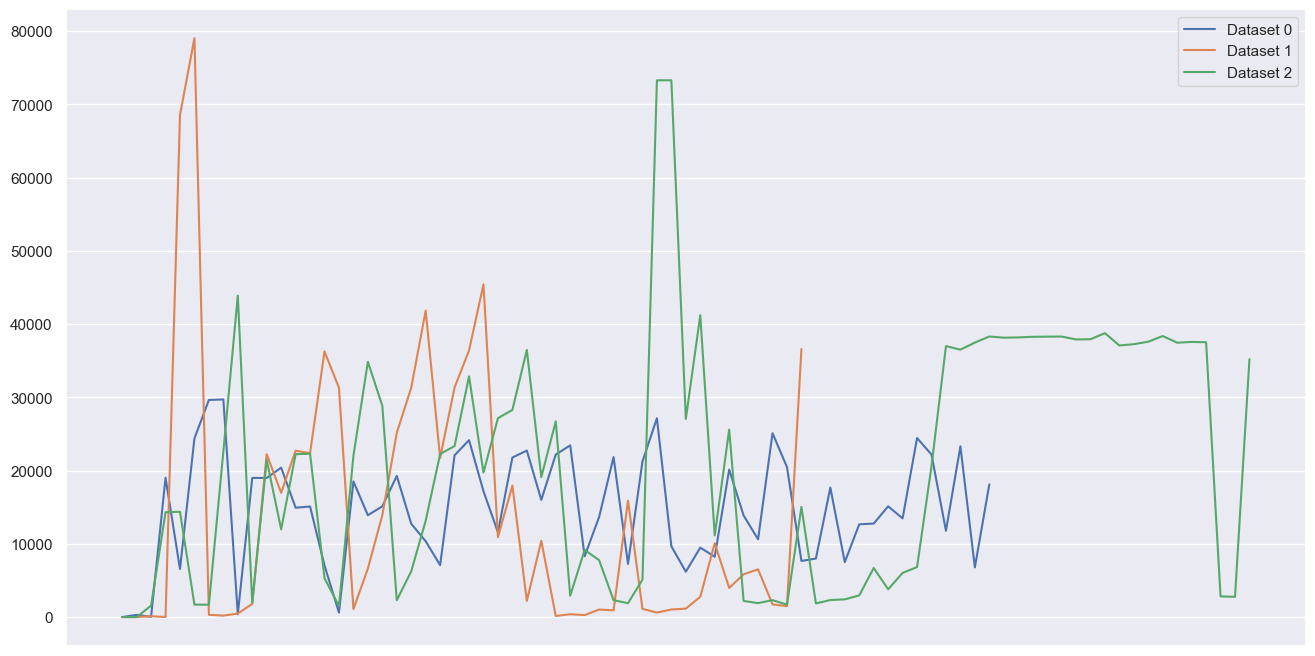

In [10]:
index = 0
for current_data in public_data:
    temp = current_data.isna().sum()
    temp.plot(label="Dataset " + str(index), xticks=[])
    index += 1

plt.legend()

 There seems to be many empty data, this needs to be remembered and taken into account during execution of smaller tasks. Removing all nans on the entire dataset would remove too much data.

#### General Visualization

In [11]:
# Country data
#Read all data
data_2011 = pd.read_csv(join(data_folder,'2011 Stack Overflow Survey Results.csv'),encoding='windows-1252')
data_2012 = pd.read_csv(join(data_folder,'2012 Stack Overflow Survey Results.csv'))
data_2013 = pd.read_csv(join(data_folder,'2013 Stack Overflow Survey Responses.csv'))
data_2014 = pd.read_csv(join(data_folder,'2014 Stack Overflow Survey Responses.csv'))
data_2015 = pd.read_csv(join(data_folder,'2015 Stack Overflow Developer Survey Responses.csv'))
data_2016 = pd.read_csv(join(data_folder,'2016 Stack Overflow Survey Responses.csv'))
data_2017 = pd.read_csv(join(data_folder,'survey_results_public2017.csv'))
data_2018 = pd.read_csv(join(data_folder,'survey_results_public2018.csv'))
data_2019 = pd.read_csv(join(data_folder,'survey_results_public2019.csv'))
data_2020 = pd.read_csv(join(data_folder,'survey_results_public2020.csv'))
data_2021 = pd.read_csv(join(data_folder,'survey_results_public2021.csv'))
data_2022 = pd.read_csv(join(data_folder,'survey_results_public2022.csv'))

country_2011 = data_2011['What Country or Region do you live in?']
country_2012 = data_2012['What Country or Region do you live in?']
country_2013 = data_2013['What Country or Region do you live in?']
country_2014 = data_2014['What Country do you live in?']
country_2015 = data_2015['Country']
country_2016 = data_2016['country']
country_2017 = data_2017['Country']
country_2018 = data_2018['Country']
country_2019 = data_2019['Country']
country_2020 = data_2020['Country']
country_2021 = data_2021['Country']
country_2022 = data_2022['Country']


country_2011.rename("Country",inplace=True)
country_2012.rename("Country",inplace=True)
country_2013.rename("Country",inplace=True)
country_2014.rename("Country",inplace=True)
country_2016.rename("Country",inplace=True)

all_countries = [country_2011, country_2012, country_2013, country_2014, country_2015, country_2016, country_2017, country_2018, country_2019, country_2020, country_2021, country_2022]

C:\Users\Cloud\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (46,48,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Cloud\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (5,108,121,196,197,198) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Cloud\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dt

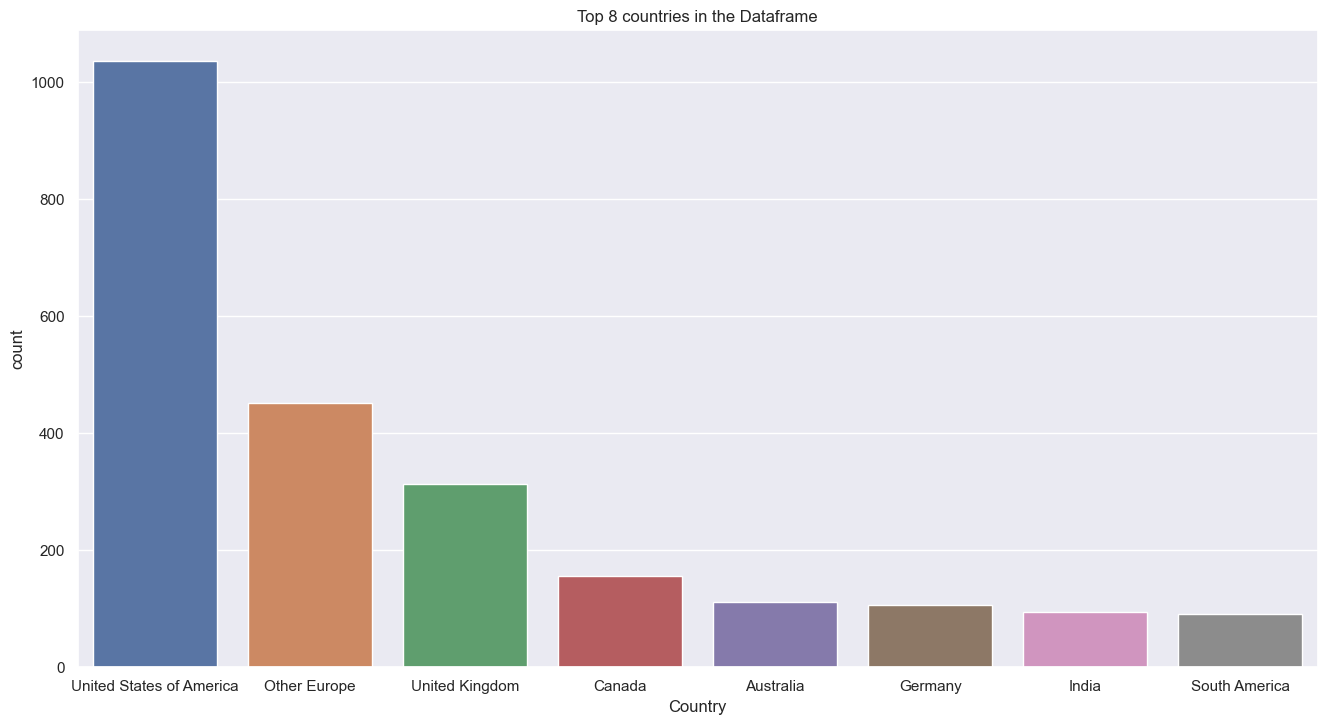

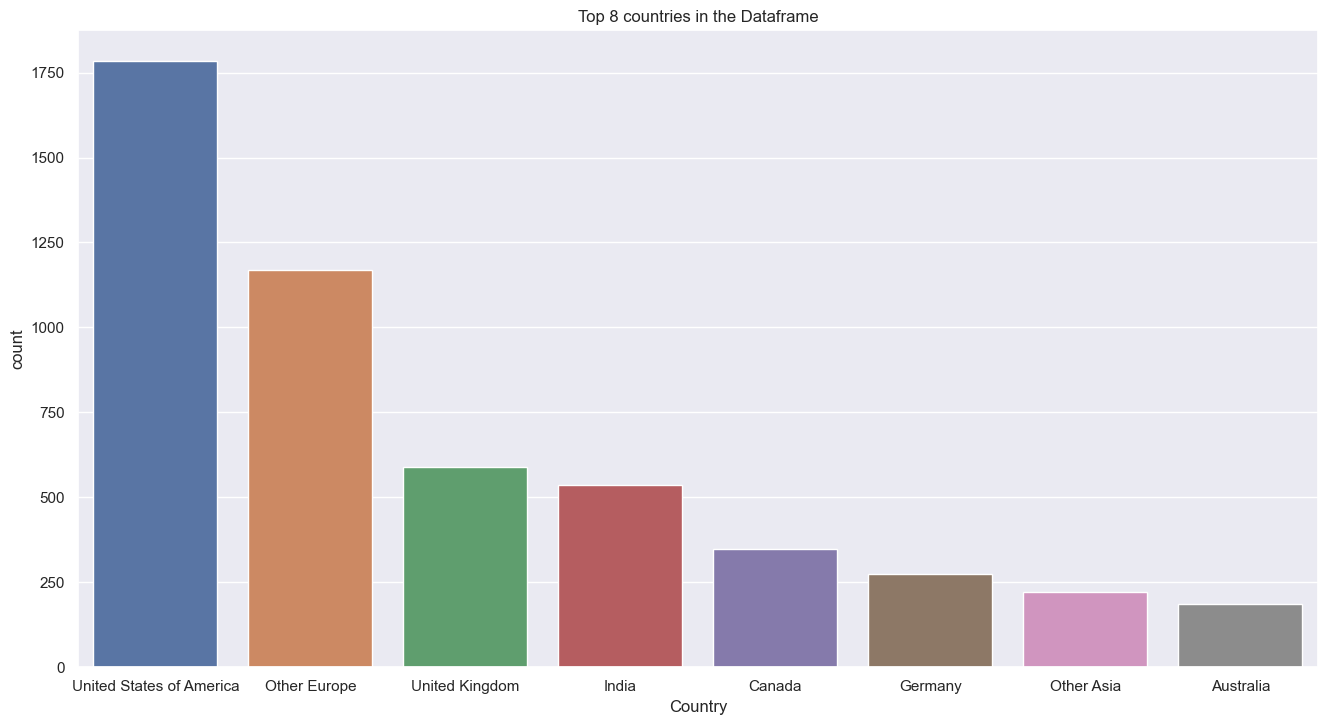

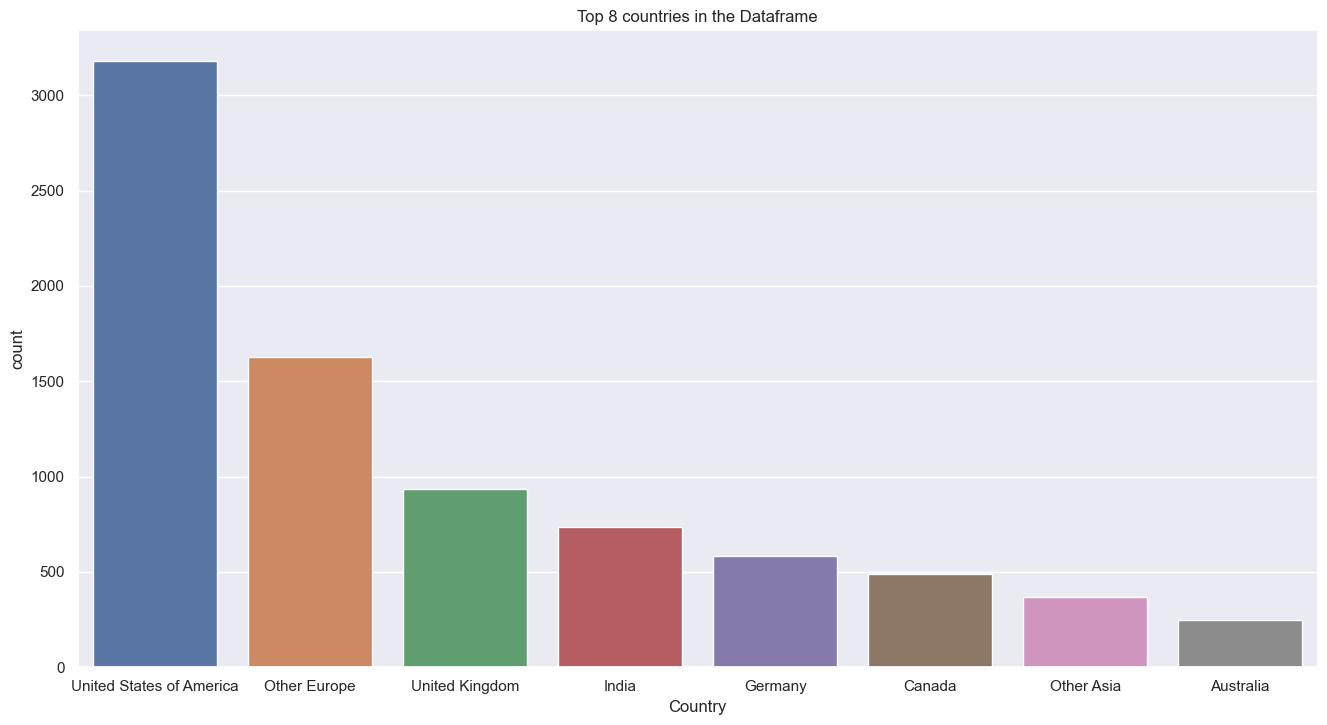

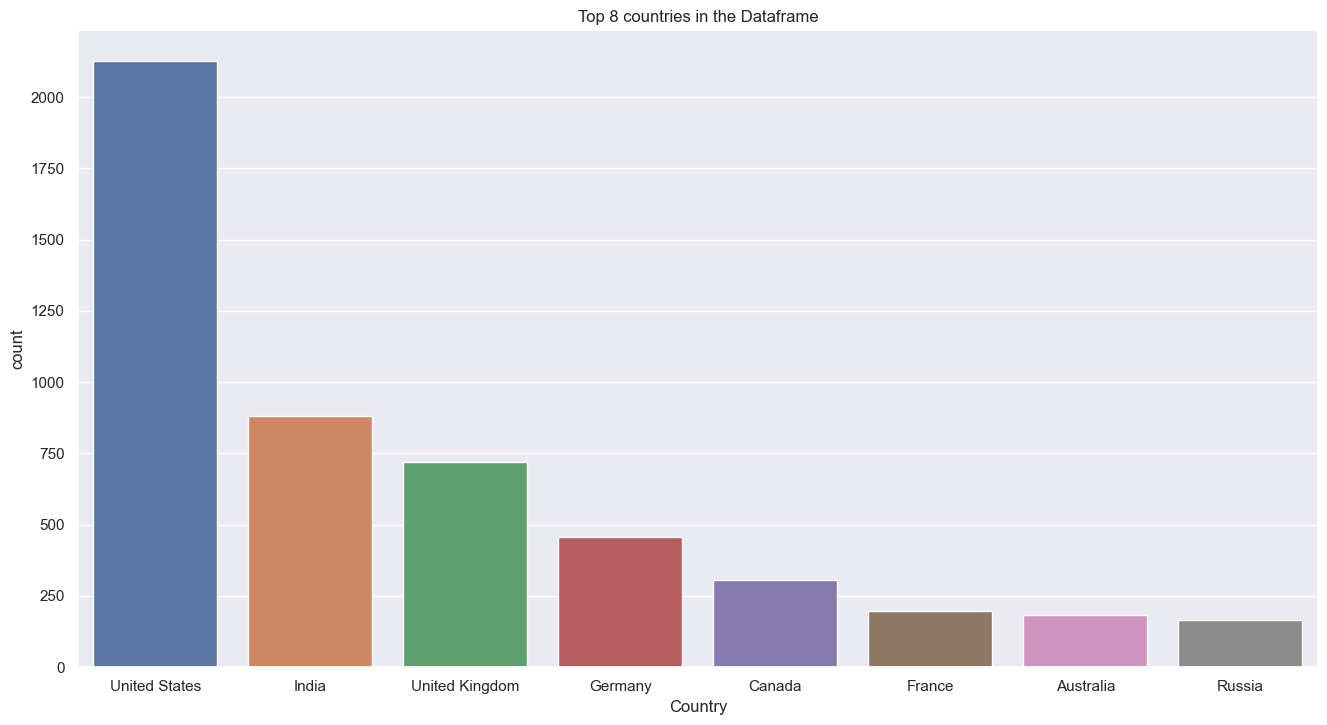

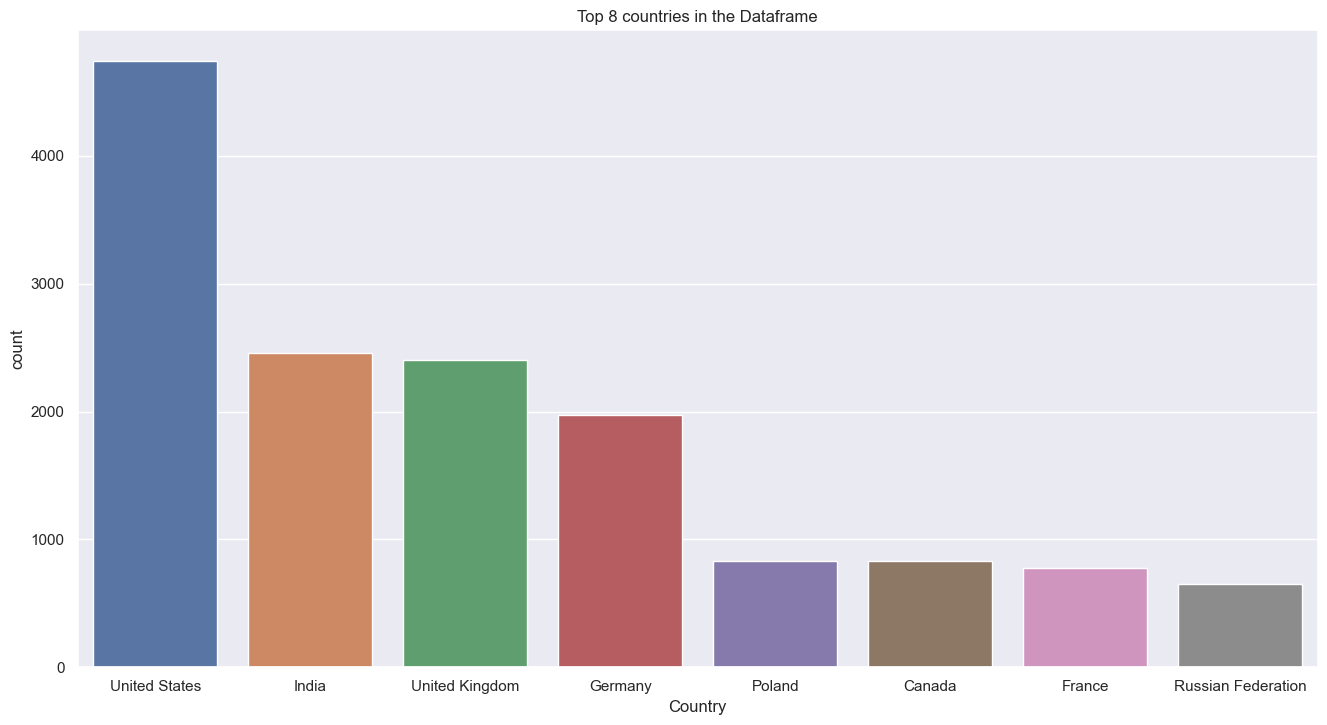

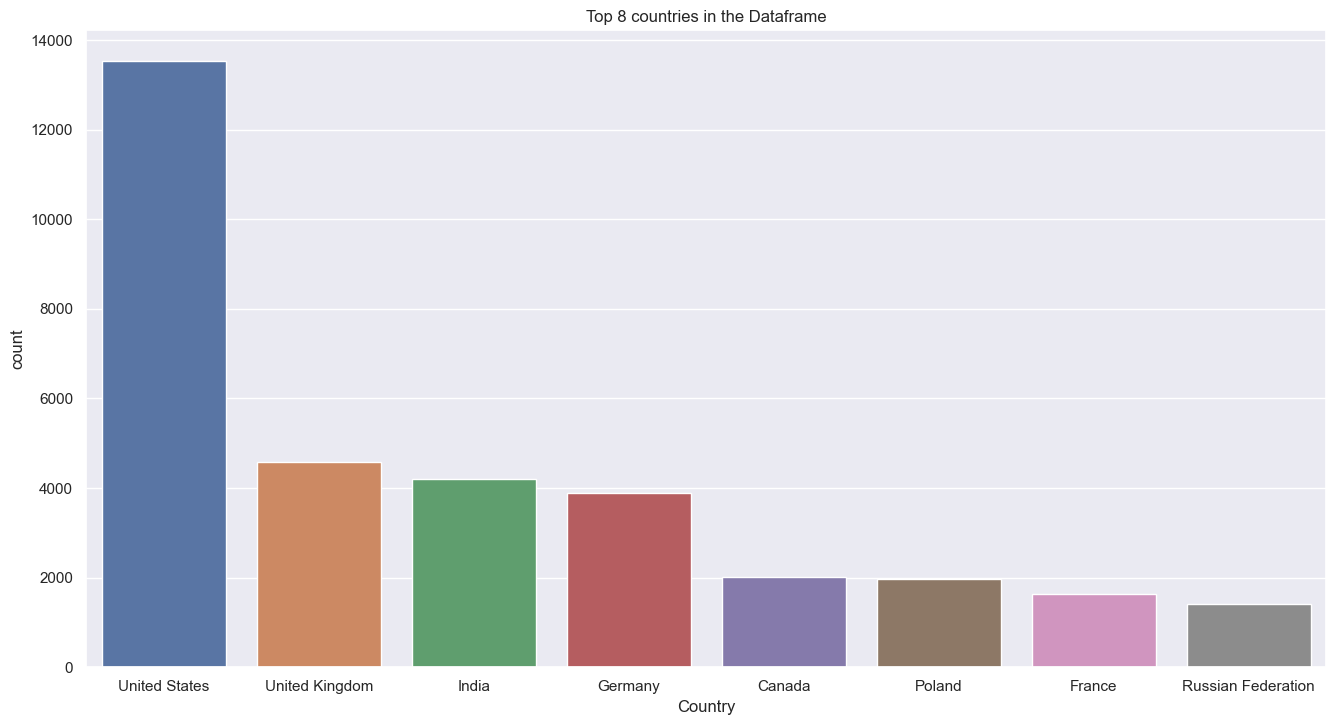

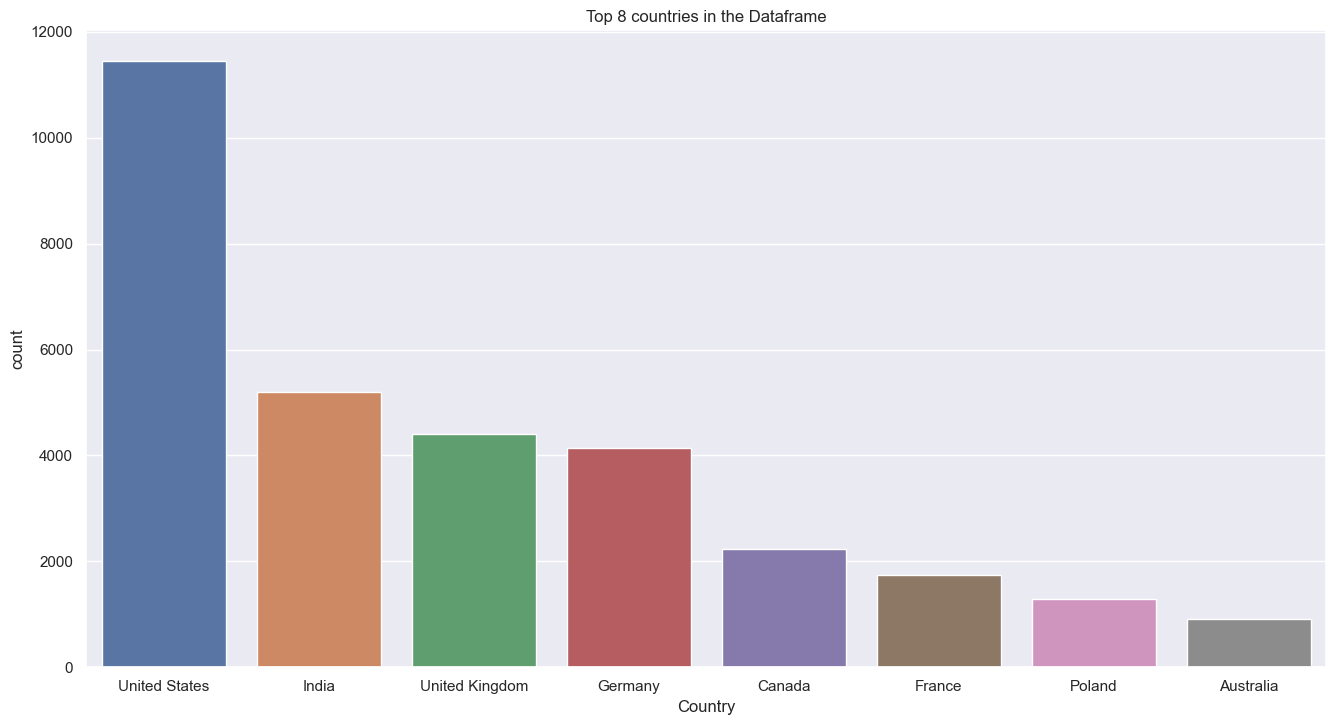

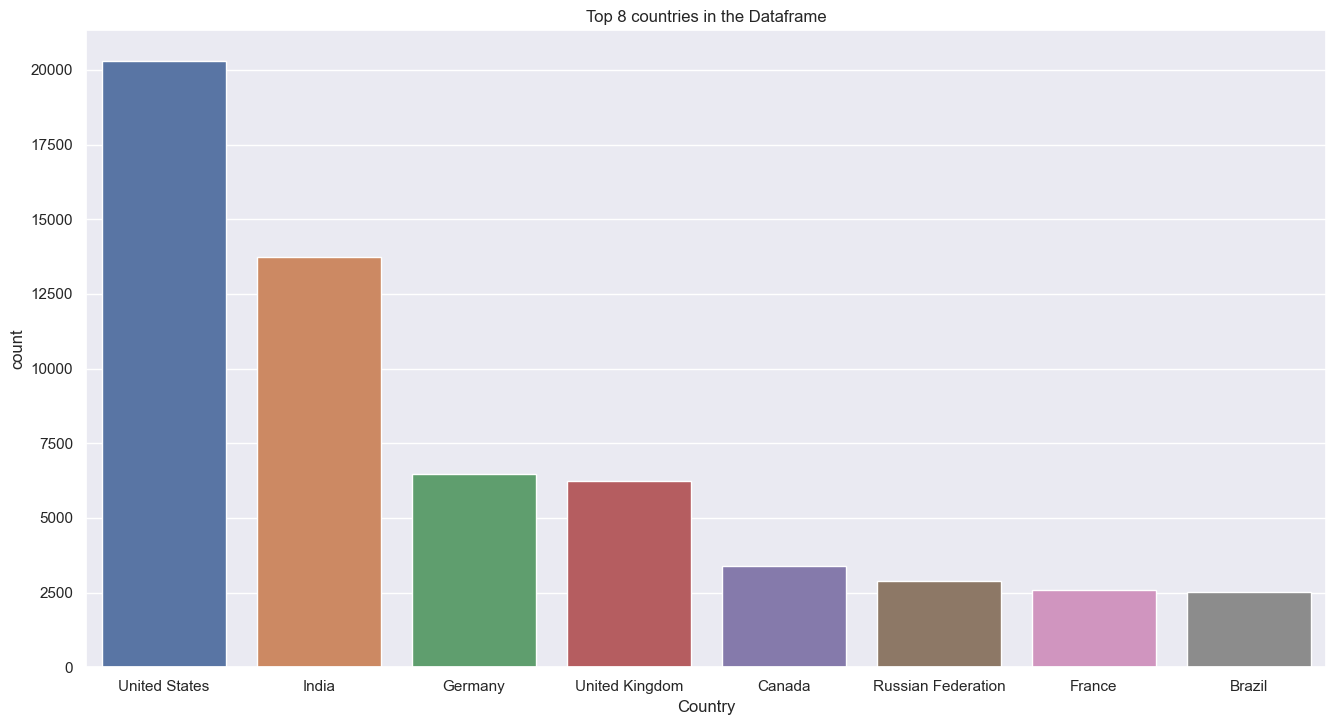

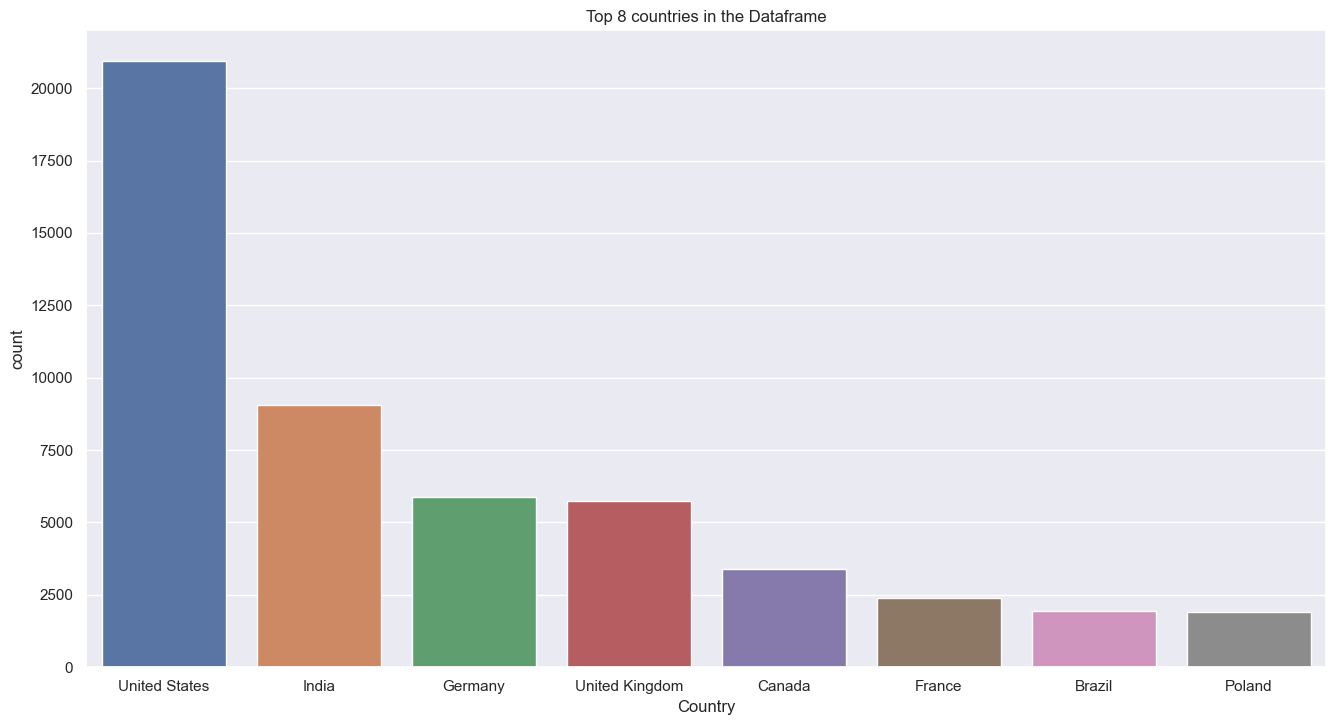

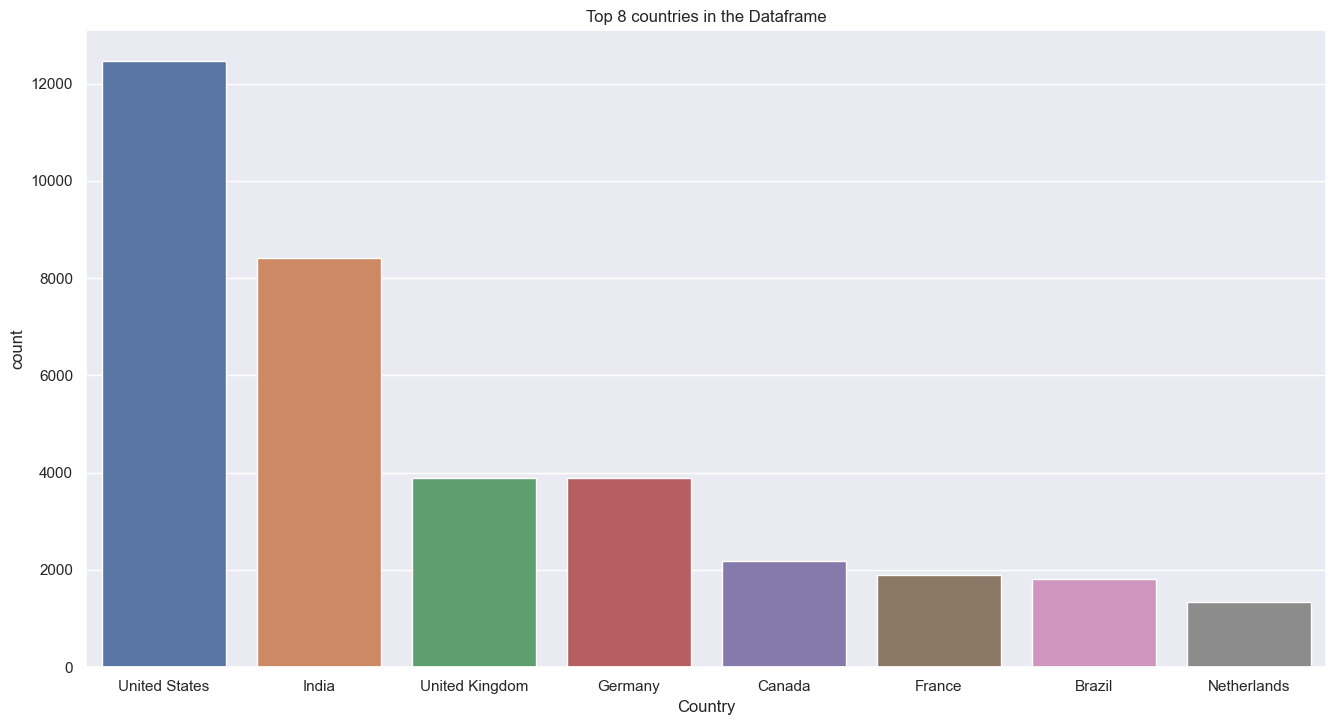

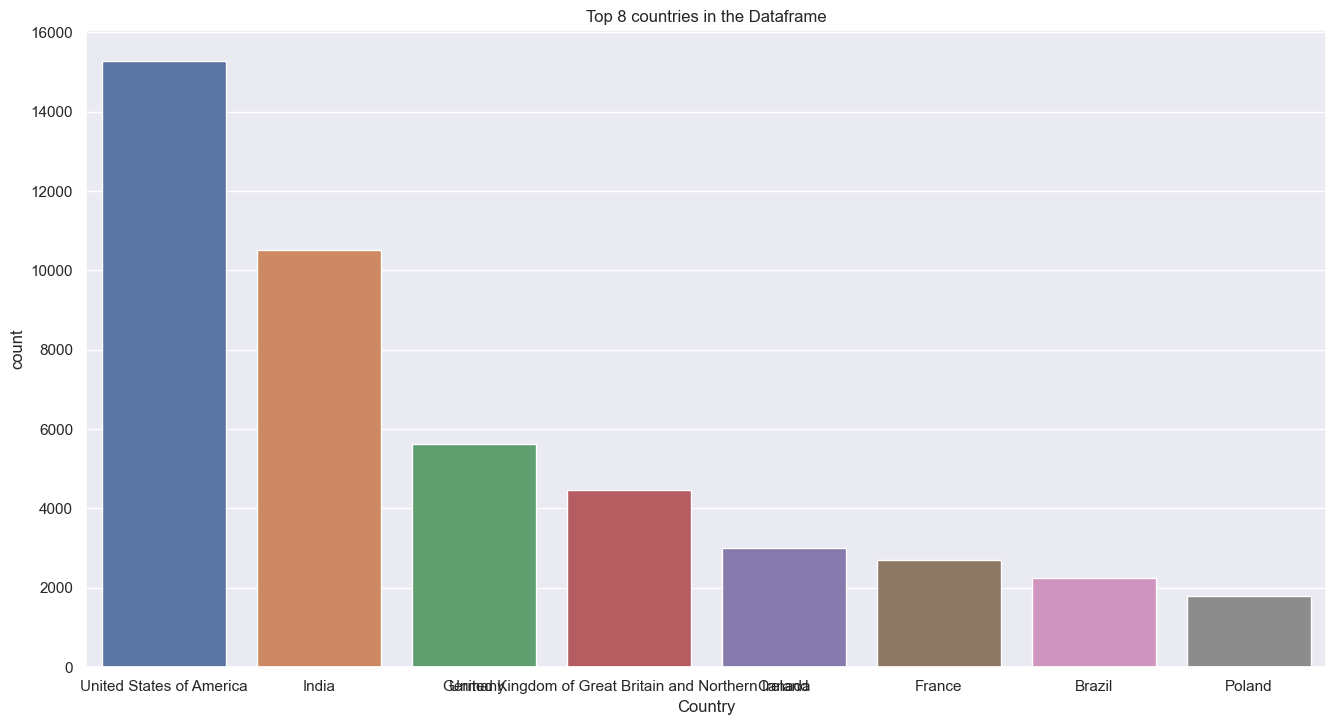

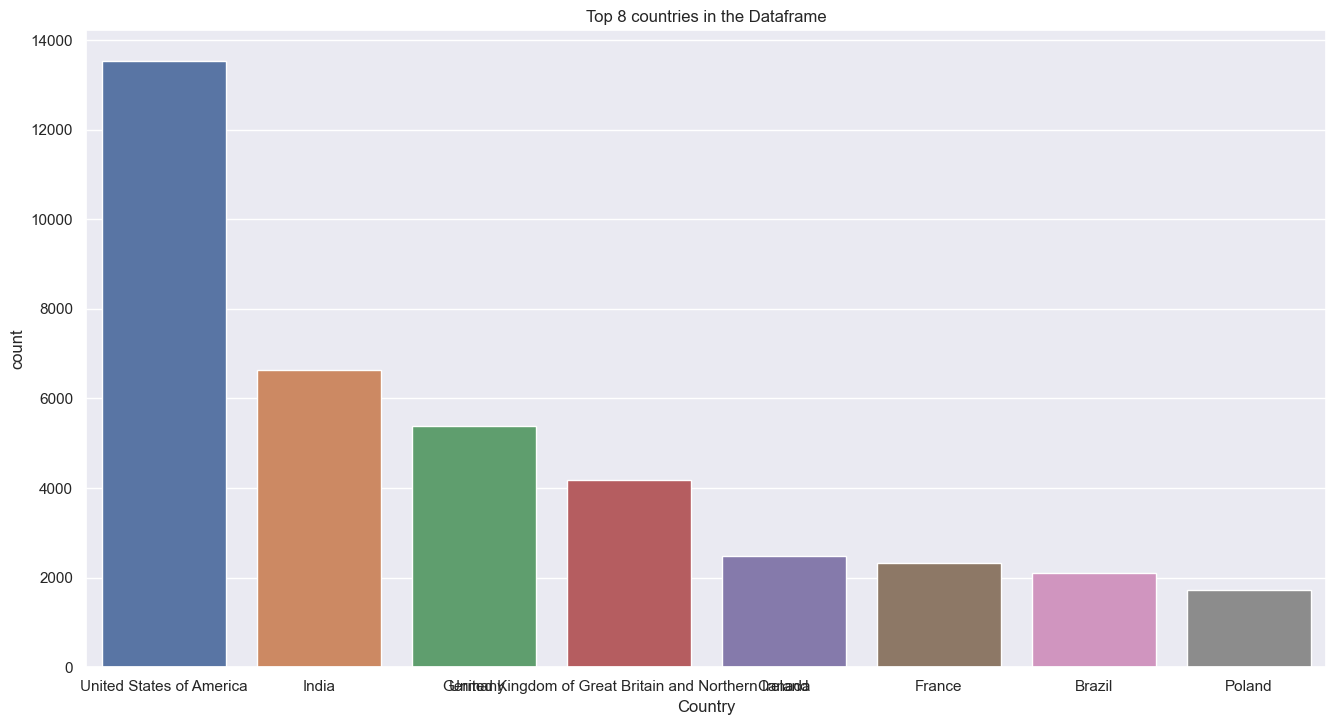

In [12]:
for df in all_countries:
    count_countries(df)